In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

from hysteresis.base import BaseHysteresis
from torchAccelerator.first_order import TorchDrift
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad

# Generate optimization data without hysteresis 1D

raw_hysterion_density:Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
raw_offset:Parameter containing:
tensor([-0.8473])
raw_scale:Parameter containing:
tensor([0.])
raw_slope:Parameter containing:
tensor([0.8473])
transformer._poly_fit.weights:Parameter containing:
tensor([0.])
transformer._poly_fit.bias:Parameter containing:
tensor([0.])
(tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000,
        0.3000, 0.2000, 0.1000, 0.0000

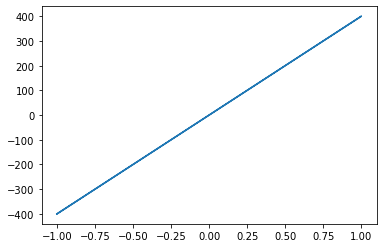

In [2]:
# Create hysteresis model
H = BaseHysteresis(
    trainable=False, 
    fixed_domain = torch.tensor((-1.0, 1.0))
)
H.slope = 800.0
H.offset = -H.slope / 2.0
H.regression()

test_applied_fields = torch.cat(
    (torch.linspace(-1,1,11) , torch.flipud(torch.linspace(-1,1,11)))
)
print(H.transformer.transform(test_applied_fields))

H.future()
M = H(test_applied_fields, return_real=True).detach()

fig,ax = plt.subplots()
ax.plot(test_applied_fields, M)

In [3]:
#create accelerator model using hysteresis models
hmodels = [deepcopy(H)]

# define quadrupoles
q1 = HysteresisQuad("q1", torch.tensor(0.01), hmodels[0])
d1 = TorchDrift("d1", torch.tensor(1.0))

HA = HysteresisAccelerator([q1, d1])

init_beam_matrix = torch.eye(6) * 1.0e-8

# set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0, 0] = 5.0e-3 ** 2
init_beam_matrix[1, 1] = 1.0e-4 ** 2
init_beam_matrix[2, 2] = 5.0e-3 ** 2
init_beam_matrix[3, 3] = 1.0e-4 ** 2
R = init_beam_matrix


In [4]:
# create objective function - log(sqrt(RMS()))
def objective(R):
    return torch.log(
        torch.sqrt(
            (torch.sqrt(R[0,0]) - 2e-3)**2
        )
    )

In [5]:
# define function to create model
from gpytorch.utils.errors import NotPSDError
from botorch import fit_gpytorch_model
from gpytorch import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from tqdm.notebook import trange
from gpytorch.likelihoods import GaussianLikelihood
from hysteresis.hybrid import ExactHybridGP


def get_model(train_X, train_Y, use_hybrid = False, h_models = None):
    if use_hybrid:
        likelihood = GaussianLikelihood()

        gpmodel = ExactHybridGP(
            train_X.clone().detach().double(),
            train_Y.clone().detach().flatten().double(), 
            h_models,
            likelihood
        )
        
        mll = ExactMarginalLogLikelihood(likelihood, gpmodel)
        fit_gpytorch_model(mll)
        
    else:
        std_trans = Standardize(1)
        gpmodel = SingleTaskGP(
            train_X.clone().detach(),
            train_Y.clone().detach(),
            outcome_transform=std_trans
        )
        mll = ExactMarginalLogLikelihood(gpmodel.likelihood, gpmodel)
        fit_gpytorch_model(mll)
    return gpmodel

In [6]:
# define optimizer function


def optimize(
        accelerator_model,
        initial_beam_matrix,
        h_models,
        steps=50,
        use_hybrid = False
):
    iterations = steps

    # initialize with a couple of points
    train_X = torch.ones((3, 1)) * 0.25
    train_X[0] = train_X[0] * 0.0
    train_X[2] = torch.tensor((0.3))
    train_Y = torch.empty((3, 1))

    for j in range(3):
        accelerator_model.apply_fields({'q1': train_X[j, 0]})

        train_Y[j] = objective(
            accelerator_model.forward(initial_beam_matrix)
        )

    print(train_X)
    print(train_Y)

    gpmodel = get_model(train_X, train_Y, use_hybrid, h_models)

    for i in trange(iterations):
        UCB = UpperConfidenceBound(gpmodel, beta=2.0, maximize=False)
        
        if use_hybrid:
            gpmodel.next()

        bounds = torch.stack([-1.0 * torch.ones(1), 1.0*torch.ones(1)])
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_X = torch.cat((train_X, candidate))

        # apply candidate
        accelerator_model.apply_fields({'q1': candidate[0,0]})

        # make next measurement
        bs = objective(
            accelerator_model(initial_beam_matrix)
        ).reshape(1, 1)
        train_Y = torch.cat((train_Y.clone(), bs.clone()))

        # train new model
        try:
            gpmodel = get_model(train_X, train_Y, use_hybrid, h_models)
        except NotPSDError:
            pass
    
    return train_X, train_Y

## Do optimization

In [12]:
train_X, train_Y = optimize(
    HA,
    R,
    hmodels,
    steps=10,
    use_hybrid=False
)

tensor([[0.0000],
        [0.2500],
        [0.3000]])
tensor([[-5.8088],
        [-6.2669],
        [-6.9309]])


  0%|          | 0/10 [00:00<?, ?it/s]

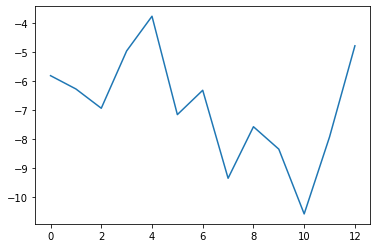

In [13]:
fig,ax = plt.subplots()
ax.plot(train_Y.detach())

{'q1': tensor(0.3502)}
tensor(-10.5705, grad_fn=<LogBackward0>)


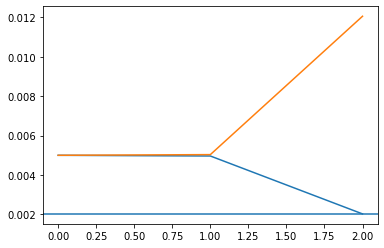

In [14]:
best_settings = train_X[torch.argmin(train_Y)]

# apply candidate
print(dict(zip(['q1','q2','q3'], best_settings)))
HA.apply_fields(dict(zip(['q1','q2','q3'], best_settings)))

beam_matrix = HA(init_beam_matrix, full=False)
fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

ax.axhline(2.0e-3)
print(objective(beam_matrix[-1]))

In [19]:
model = get_model(train_X, train_Y, use_hybrid = True, h_models = hmodels)

In [20]:
for name, param in model.named_parameters():
    print(f'{name}:{param}')

likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-0.3652], requires_grad=True)
hysteresis_models.0.raw_hysterion_density:Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
hysteresis_models.0.raw_offset:Parameter containing:
tensor([-0.8473])
hysteresis_models.0.raw_scale:Parameter containing:
tensor([0.])
hysteresis_models.0.raw_slope:Parameter containing:
tensor([0.8473])
hysteresis_models.0.transformer._poly_fit.weights:Parameter containing:
tensor([0.])
hysteresis_models.0.transformer._poly_fit.bias:Parameter containing: